In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.path import Path
from matplotlib.patches import PathPatch

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)

%load_ext autoreload
%autoreload 2

%matplotlib ipympl

In [2]:
import sys

sys.path.append('.')
sys.path.append('..')

In [3]:
import os
from tqdm.notebook import tqdm
import zipfile
from scipy.spatial.distance import pdist, squareform

from pyproj import CRS, Transformer
import urllib.request
from urllib.error import HTTPError
import subprocess

import time


from utils.misc import bounded_voronoi
from utils.plotting import to_colors
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

In [4]:
from ndgsp import ProductGraph, Graph, GSR, MultivariateFilterFunction, UnivariateFilterFunction, KGR, RNC, KGRNC


from scipy.optimize import minimize
from sklearn.linear_model import Ridge

Using Jax backend with device gpu:0


In [7]:
# set start and end year for data
START = 2012
END = 2022

# set root folder to work in 
# raw data is ~ 10GB
DATA_DIR = '/media/ed/DATA/Datasets/AirQuality'


def download_data():
    """
    Download an extract the files available at https://aqs.epa.gov/aqsweb/airdata/download_files.html
    """
    
    base_url = 'https://aqs.epa.gov/aqsweb/airdata'
    
    metrics = [44201, 42401, 42101, 42602, 88101, 81102, 'NONOxNOy', 'WIND', 'TEMP', 'PRESS', 'RH_DP']
    
    for metric, year in tqdm([(metric, year) for metric in metrics for year in range(START, END + 1)]):
        
        zip_name = f'daily_{metric}_{year}.zip'
        csv_name = f'daily_{metric}_{year}.csv'
        
        # create 'raw' sub-folder to save raw data to
        os.makedirs(os.path.join(DATA_DIR, 'raw'), exist_ok=True)

        url = os.path.join(base_url, zip_name)
        zip_uri = os.path.join(DATA_DIR, 'raw', zip_name)
        csv_uri = os.path.join(DATA_DIR, 'raw', csv_name)        
        
        # if the csv does not exist, go download the zip file
        if not os.path.isfile(csv_uri):
            
            try:
                
                urllib.request.urlretrieve(url, zip_uri)
                
                # extract zip file to csv
                with zipfile.ZipFile(zip_uri, 'r') as zip_ref:
                    zip_ref.extractall(DATA_DIR)

                os.remove(zip_uri)
                
            except HTTPError as e:
                print(f'{url}: {e}')

    urllib.request.urlretrieve('https://incidents.fire.ca.gov/imapdata/mapdataall.csv', os.path.join(DATA_DIR, 'fires.csv'))        

In [ ]:
# download_data()

In [6]:
def clean_data(metric):
    """
    Use the raw data to create a df of clean data
    """
    
    usecols = ['State Code', 'County Code', 'Site Num', 'POC', 'Parameter Name', 'Sample Duration', 'Date Local', 'Arithmetic Mean']
    
    df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, 'raw', f'daily_{metric}_{year}.csv'), usecols=usecols) for year in range(START, END + 1)])
    
    # take California only
    df = df[df['State Code'] == 6]
    
    # for these metrics, select 1H duration
    if metric in [88101, 42401, 42101]:
        df = df[df['Sample Duration'] == '1 HOUR']
    
    # just take RH
    if metric == 'RH_DP':
        df = df[df['Parameter Name'].str.strip() == 'Relative Humidity']

    # just take NO
    if metric == 'NONOxNOy':
        df = df[df['Parameter Name'] == 'Nitric oxide (NO)']
        
    df = df.drop(['State Code', 'Sample Duration', 'Parameter Name'], axis=1)
    
    df['Date Local'] = pd.to_datetime(df['Date Local'])
    
    clean_df = pd.DataFrame()

    for code, subdf in df.groupby(['County Code', 'Site Num', 'POC']):

        subdf = subdf.drop(['County Code', 'Site Num', 'POC'], axis=1).set_index('Date Local', drop=True).rename({'Arithmetic Mean': code}, axis=1)
        
        # some dates duplicated
        subdf = subdf[~subdf.index.duplicated()]
        
        clean_df = pd.concat([clean_df, subdf], axis=1)
        
    return clean_df
    

In [19]:
def save_clean_data():

    metrics = [44201, 42401, 42101, 42602, 88101, 81102, 'NONOxNOy', 'WIND', 'TEMP', 'PRESS', 'RH_DP']

    for metric in metrics:
            
        clean_df = clean_data(metric)
        
        clean_df.to_csv(os.path.join('../data', 'cali',  'processed', f'{metric}.csv'))

In [27]:
# f_paths = [os.path.join('../data', 'cali', 'processed', fname) for fname in os.listdir(os.path.join('../data', 'cali', 'processed')) if fname.endswith('csv')]
# data = {path.split('/')[-1].split('.')[0]: pd.read_csv(path, index_col=0, parse_dates=True) for path in f_paths}

In [5]:
def get_data(sites):

    f_paths = [os.path.join('../data', 'cali', 'processed', fname) for fname in os.listdir(os.path.join('../data', 'cali', 'processed')) if fname.endswith('csv')]

    data = {path.split('/')[-1].split('.')[0]: pd.read_csv(path, index_col=0, parse_dates=True) for path in f_paths}

    for key in data.keys():

        data[key].columns = ['{}_{}_{}'.format(*site[1:-1].split(', ')) for site in data[key].columns]

        if key in ['NONOxNOy', '88101', '81102', '42602']:

            data[key] = np.log(1 + data[key]).replace([np.inf, -np.inf], np.nan)

    max_ind = max([df.index for df in data.values()], key=len)

    for key in data.keys():

        data[key] = data[key].reindex(sites.index, axis=1)
        data[key] = data[key].reindex(max_ind, axis=0) 
    
    return data


def get_fire(data):

    fire = pd.read_csv(os.path.join('../data', 'cali', 'fires.csv'), usecols=['incident_name', 'incident_county', 'incident_acres_burned', 'incident_longitude', 'incident_latitude', 'incident_dateonly_created', 'incident_dateonly_extinguished'], parse_dates=[5, 6]).dropna()

    fire = fire[(fire['incident_dateonly_created'] > data['PRESS'].index[0]) & (fire['incident_dateonly_extinguished'] < data['PRESS'].index[-1])]


    locii =[(-123.9, 41.8), 
            (-120.3, 41.8), 
            (-122.1, 40.35), 
            (-121.2, 39.4), 
            (-122.8, 38.8), 
            (-121.7, 37.4), 
            (-119.6, 37.3), 
            (-120.9, 35.6), 
            (-118.6, 34.5), 
            (-116.8, 33.5)]
    
    cali = np.load('../data/cali/cali_coords.npy')

    contained = Path(cali).contains_points(fire[['incident_longitude', 'incident_latitude']].values)

    fire['region'] = cdist(fire[['incident_longitude', 'incident_latitude']].values, locii).argmin(axis=1)

    out = pd.DataFrame(index=data['PRESS'].index, columns=range(len(locii)))

    out.loc[:, :] = 0

    for i, row in fire.iterrows():

        start = row['incident_dateonly_created']
        end = row['incident_dateonly_extinguished']

        if (end - start).days > 0:

            region = row['region']
            burned = row['incident_acres_burned']
            out.loc[start:end, region] = burned / (end - start).days

    return out.apply(pd.to_numeric)

def get_sites():
    return pd.read_csv('../data/cali/sites2.csv', index_col=0)

In [6]:
sites = get_sites()
data = get_data(sites)
fire = get_fire(data)

/home/ed/miniconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/ed/miniconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [7]:
def get_X_(fire, data):
    """
    Get the exogenous variables
    """

    X_ = fire.copy()
    X_ /= np.std(X_.values)
    X_['season_1'] = np.cos(2 * np.pi * pd.Series(fire.index).dt.day_of_year / 365).values
    X_['season_2'] = np.sin(2 * np.pi * pd.Series(fire.index).dt.day_of_year / 365).values

    X_['t'] = 5 * np.linspace(-1, 1, len(X_))

    for met in ['PRESS', 'RH_DP', 'TEMP']:

        pca = PCA(n_components=5)
        
        df = pd.read_csv(f'../data/cali/reconstructed/{met}.csv', index_col=0)

        df = df.loc[:, ~pd.isnull(data[met]).all(0)]

        df -= df.values.mean()
        df /= df.values.std()

        df = pca.fit_transform(df.values)

        X_[[f'{met}_PCA_{i}' for i in range(5)]] = df

    return X_


    



In [8]:
X_ = get_X_(fire, data)

In [9]:
def get_graph():

    cali = np.load('../data/cali/cali_xy.npy')

    contained = Path(cali).contains_points(sites[['x', 'y']].values)

    regions = bounded_voronoi(points=sites.loc[contained, ['x', 'y']], boundary=cali)

    paths = [[Path(sub_region) for sub_region in region] for region in regions]

    A = np.zeros((len(paths), len(paths)))

    for i, plist1 in tqdm(enumerate(paths), total=A.shape[0]):

        for j, plist2 in enumerate(paths):

            if i == j:
                break

            for path1 in plist1:
                for path2 in plist2:
                    if path1.intersects_path(path2):
                        A[i, j] = 1
                        A[j, i] = 1

    A *= 50000 / (50000 + squareform(pdist(sites[['x', 'y']].values)))

    L  = np.diag(A.sum(0)) - A
    
    return A, L

In [10]:
A, L = get_graph()

  0%|          | 0/571 [00:00<?, ?it/s]

In [11]:
def reconstruct(data_raw):

    np.random.seed(0)

    # make sure the data has correct columns
    data_raw = data_raw.reindex(sites.index, axis=1)

    # make a copy - this will have additional training nans
    data_train = data_raw.copy()

    # add nans in strings of 100
    for i in range(len(data_train.columns)):
        for _ in range(3):
            s = np.random.randint(0, len(data_raw) - 100)
            data_train.iloc[s:s + 100, i] = np.nan

    ix, iy = np.argwhere((~np.isnan(data_raw.values) & np.isnan(data_train.values))).T

    def square_error(pred):
        return ((pred[ix, iy] - data_raw.values[ix, iy]) ** 2).sum()
    
    def objective(params):

        gamma, beta1, beta2 = np.exp(params)

        mod.set_gamma(gamma)
        mod.set_beta([beta1, beta2])

        pred = mod.compute_mean(denormalise=True)

        err = square_error(pred) 

        print(f'Params: γ={gamma:.4e}, β=[{beta1:.4e}, {beta2:.4e}]. Error = {err:.4e}', end='\r')

        return err

    g = ProductGraph(graphs=[Graph.chain(3957), Graph.from_adjacency(A)])

    fil = MultivariateFilterFunction.diffusion([1, 1])

    mod = GSR(data_train, graph=g, filter_func=fil, gamma=1.0, normalise=True)

    res = minimize(objective, x0=[0, 0, 0], method='Nelder-Mead', options={'maxiter': 100})

    gamma, beta1, beta2 = np.exp(res.x)

    mod = GSR(data_raw, graph=g, filter_func=fil, gamma=1.0, normalise=True)
    mod.set_gamma(gamma)
    mod.set_beta([beta1, beta2])

    res = np.array(mod.compute_mean(denormalise=True))

    ix, iy = np.argwhere(~np.isnan(data_raw.values)).T

    res[ix, iy] = data_raw.values[ix, iy]

    print()

    return res



def get_X(use_saved=True):
    """
    Get the endogenous variables
    """

    if use_saved:
        gases = np.stack([pd.read_csv(f'../data/cali/reconstructed/{gas}.csv', index_col=0).values for gas in ['42101', '42401', '44201', '81102', 'NONOxNOy', '42602']], axis=-1)
    
    else:
        gases = np.stack([reconstruct(data[gas]) for gas in ['42101', '42401', '44201', '81102', 'NONOxNOy', '42602']], axis=-1)

    site_desc = pd.get_dummies(sites[['Land Use', 'Location Setting']]).values.astype(float)

    site_desc = np.repeat(site_desc[None, :, :], gases.shape[0], axis=0)

    return np.concatenate([gases, site_desc], axis=-1)


In [12]:
X = get_X()

In [ ]:
# Params: γ=4.0976e-03, β=[4.1784e+00, 1.4259e+01]. Error = 5.9115e+02
# Params: γ=4.2595e-02, β=[1.0249e+03, 4.9980e-04]. Error = 1.8601e+03
# Params: γ=1.2312e-02, β=[1.8661e+00, 1.4563e+00]. Error = 2.7041e+00
# Params: γ=6.4699e-03, β=[4.0798e+00, 3.4577e+00]. Error = 6.2812e+05
# Params: γ=4.5086e-03, β=[1.7957e+00, 9.8263e+00]. Error = 1.0651e+08
# Params: γ=3.2688e-02, β=[2.6126e+00, 4.9535e-01]. Error = 1.6388e+06
# Params: γ=2.4656e-02, β=[1.3970e+00, 1.2693e+00]. Error = 8.0457e+05

In [27]:
def get_train_data(data_raw):

    np.random.seed(0)

    # make a copy - this will have additional training nans
    data_train = data_raw.copy()

    # add nans in strings of 100
    for i in range(len(data_train.columns)):
        for _ in range(3):
            s = np.random.randint(0, len(data_raw) - 100)
            data_train.iloc[s:s + 100, i] = np.nan

    return data_train


def get_train_data2(Y0):

    np.random.seed(0)

    # make a copy - this will have additional training nans
    Y_train = Y0.copy()

    # 136 non null cols
    non_null_cols = Y0.columns[(~np.isnan(Y0)).sum() > 0].tolist()
    np.random.shuffle(non_null_cols)

    val_cols = non_null_cols[:13]
    test_cols = non_null_cols[13:26]
    train_cols = non_null_cols[26:]

    Y_train[val_cols] = np.nan
    Y_train[test_cols] = np.nan

    return Y_train, train_cols, val_cols, test_cols

In [28]:
Y0 = data['88101']
Y_train, train_cols, val_cols, test_cols = get_train_data2(Y0)


# ix, iy = np.argwhere((~np.isnan(data_raw.values) & np.isnan(data_train.values))).T


def square_error(pred, cols):
    # warning: must have pandas version > 2.0
    return ((pred[cols] - Y0[cols]) ** 2).mean(axis=None)


def r_squared(pred, cols):
    return 1 - ((pred[cols] - Y0[cols]) ** 2).mean(axis=None) / ((Y0[cols] - Y0[cols].mean(axis=None)) ** 2).mean(axis=None)

In [19]:
def get_best_kgr_model():

    MAX_ITERS = 100
    its = 0

    g_kgr = Graph.from_adjacency(A)
    fil_kgr = UnivariateFilterFunction.diffusion(1)
    model_kgr = KGR(X_.values, Y_train, g_kgr, fil_kgr, gamma=1e-2, kernel_std=1e-1)

    all_params = []
    errs = []

    def loss(params):
        nonlocal its

        all_params.append(params)
        gamma, kstd, beta = np.exp(params)

        model_kgr.set_gamma(gamma)
        model_kgr.set_kernel_std(kstd)
        model_kgr.set_beta(beta)

        pred = model_kgr.solve()
        err = float(square_error(pred, val_cols))
        errs.append(err)
    
        its += 1
        print(f'Params: gamma={gamma:.4e}, kstd={kstd:.4e}, beta={beta:.4e}. RMSE={err ** 0.5:.4e}. Iterations: {its}', end='\r')
        
        if its >= MAX_ITERS:
            raise KeyboardInterrupt
        
        return err
    

    try:
        params0 = [8.2203e-03, 3.7607e-03, 4.8425e+00]
        out = minimize(loss, x0=np.log(params0), method='Nelder-Mead')

    except KeyboardInterrupt:
        pass

    print('\n')

    return model_kgr, np.array(all_params), np.array(errs)


def get_best_rnc_model():

    MAX_ITERS = 100
    its = 0

    g_rnc = ProductGraph(graphs=[Graph.chain(3957), Graph.from_adjacency(A)])
    fil_rnc = MultivariateFilterFunction.diffusion([1, 1])
    model_rnc = RNC(X, Y_train, g_rnc, fil_rnc, gamma=2e-2, lam=1)

    all_params = []
    errs = []

    def loss(params):
        nonlocal its

        all_params.append(params)
        gamma, beta1, beta2, lam = np.exp(params)

        model_rnc.set_gamma(gamma)
        model_rnc.set_beta([beta1, beta2])
        model_rnc.set_lam(lam)

        pred = model_rnc.solve()
        err = float(square_error(pred, val_cols))
        errs.append(err)
    
        its += 1
        print(f'Params: gamma={gamma:.4e}, beta=[{beta1:.4e}, {beta2:.4e}], lam={lam:.4e}. RMSE={err ** 0.5:.4e}. Iterations: {its}', end='\r')
        
        if its >= MAX_ITERS:
            raise KeyboardInterrupt
        
        return err
    

    try:
        params0 = [1.2675e-02, 1.6118e-01, 4.2660e+00, 4.9934e-01]
        out = minimize(loss, x0=np.log(params0), method='Nelder-Mead')

    except KeyboardInterrupt:
        pass

    print('\n')

    return model_rnc, np.array(all_params), np.array(errs)


def get_best_kgrnc_model():

    MAX_ITERS = 100
    its = 0

    g_kgrnc = Graph.from_adjacency(A)
    fil_kgrnc = UnivariateFilterFunction.diffusion(1)
    model_kgrnc = KGRNC(X, X_.values, Y_train, g_kgrnc, fil_kgrnc, gamma=7.5e-03, kernel_std=1e-3, lam=1)

    all_params = []
    errs = []

    def loss(params):
        nonlocal its

        all_params.append(params)
        gamma, kstd, beta, lam = np.exp(params)

        model_kgrnc.set_gamma(gamma)
        model_kgrnc.set_kernel_std(kstd)
        model_kgrnc.set_beta(beta)

        pred = model_kgrnc.solve()
        err = float(square_error(pred, val_cols))
        errs.append(err)
    
        its += 1
        print(f'Params: gamma={gamma:.4e}, kstd={kstd:.4e}, beta={beta:.4e}, lam={lam:.4e}. RMSE={err ** 0.5:.4e}. Iterations: {its}', end='\r')
        
        if its >= MAX_ITERS:
            raise KeyboardInterrupt
        
        return err
    
    try:
        params0 = [4.5048e-02, 2.2430e-04, 1.0015e+00, 1.0004e+00]
        out = minimize(loss, x0=np.log(params0), method='Nelder-Mead')

    except KeyboardInterrupt:
        pass

    print('\n')

    return model_kgrnc, np.array(all_params), np.array(errs)

In [20]:
res_rnc = get_best_rnc_model()

Params: gamma=1.1608e-02, beta=[1.6284e-01, 4.0496e+00], lam=4.9653e-01. RMSE=4.2718e-01. Iterations: 98



In [21]:
res_kgr = get_best_kgr_model()

Params: gamma=1.3361e-02, kstd=1.3905e-03, beta=3.6174e+00. RMSE=4.4400e-01. Iterations: 99



In [22]:
res_kgrnc = get_best_kgrnc_model()

Params: gamma=2.7446e-02, kstd=2.8491e-04, beta=1.0016e+00, lam=1.0004e+00. RMSE=4.4267e-01. Iterations: 100



In [ ]:
Y_ridge_global = Y_train.fillna(Y_train.mean(), axis=0).T.fillna(Y_train.T.mean(), axis=0).T.fillna(Y_train.mean(axis=None))
X_ridge_global = X_.values
ridge_global = Ridge(alpha=1.0563e1).fit(X_ridge_global, Y_ridge_global)

Y_ridge_local = Y_train.values.reshape(-1)[~np.isnan(Y_train.values.reshape(-1))]
X_ridge_local = X.reshape(-1, 17)[~np.isnan(Y_train.values.reshape(-1)), :]
ridge_local = Ridge(alpha=2.110e1).fit(X_ridge_local, Y_ridge_local)

In [55]:
names = ['KGR', 'RNC', 'KG-RNC', 'Ridge (global)', 'Ridge (local)']

predictions = [res_kgr[0].solve(), res_rnc[0].solve(), res_kgrnc[0].solve(), 
               pd.DataFrame(ridge_global.predict(X_ridge_global), columns=Y0.columns, index=Y0.index), 
               pd.DataFrame(ridge_local.predict(X.reshape(-1, 17)).reshape(Y0.shape), columns=Y0.columns, index=Y0.index)]

RMSE = pd.DataFrame(columns=['Train', 'Val', 'Test'], index=names)
R_sq = pd.DataFrame(columns=['Train', 'Val', 'Test'], index=names)

for pred, name in zip(predictions, names):

    RMSE.loc[name, 'Train'] =  square_error(pred, train_cols) ** 0.5
    RMSE.loc[name, 'Val'] =  square_error(pred, val_cols) ** 0.5
    RMSE.loc[name, 'Test'] =  square_error(pred, test_cols) ** 0.5

    R_sq.loc[name, 'Train'] =  r_squared(pred, train_cols)
    R_sq.loc[name, 'Val'] =  r_squared(pred, val_cols)
    R_sq.loc[name, 'Test'] =  r_squared(pred, test_cols)

In [129]:
Y0.index[1000]

Timestamp('2014-09-27 00:00:00')

In [62]:
R_sq

,Train,Val,Test
KGR,0.782485,0.49391,0.504038
RNC,0.802734,0.531527,0.642544
KG-RNC,0.903313,0.496938,0.643199
Ridge (global),0.487293,0.079052,0.139089
Ridge (local),0.417992,0.287903,0.447736


In [126]:
Y0.isnull().values.sum() / np.prod(Y0.shape)

0.8804738504598691

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_pred/cali_preds_plot.pdf'.


CompletedProcess(args=['pdfcrop', 'cali_pred/cali_preds_plot.pdf', 'cali_pred/cali_preds_plot.pdf'], returncode=0)

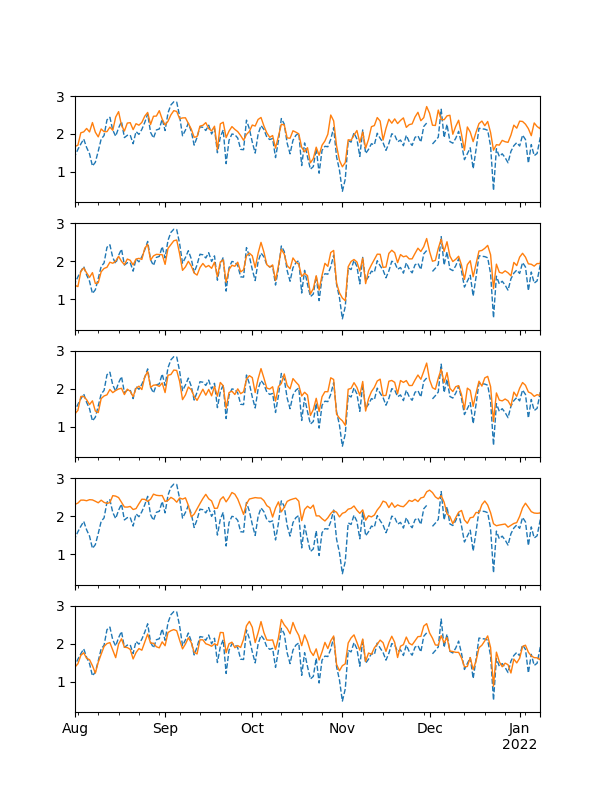

In [123]:
fig, axes = plt.subplots(nrows=5, figsize=(6, 8), sharex=True)

for i, name in enumerate(names):

    Y0[col].plot(label='Ground Truth', ax=axes[i], lw=1, ls='--')
    predictions[i][col].plot(label=name, ax=axes[i], lw=1)

    axes[i].set_xlim(18840.0, 19000.0)
    axes[i].set_ylim(0.2, 3)


plt.xlabel('')

plt.savefig('cali_pred/cali_preds_plot.pdf')

subprocess.run(['pdfcrop', 'cali_pred/cali_preds_plot.pdf', 'cali_pred/cali_preds_plot.pdf'])

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_pred_map/cali_preds_plot.pdf'.


CompletedProcess(args=['pdfcrop', 'cali_pred_map/cali_preds_plot.pdf', 'cali_pred_map/cali_preds_plot.pdf'], returncode=0)

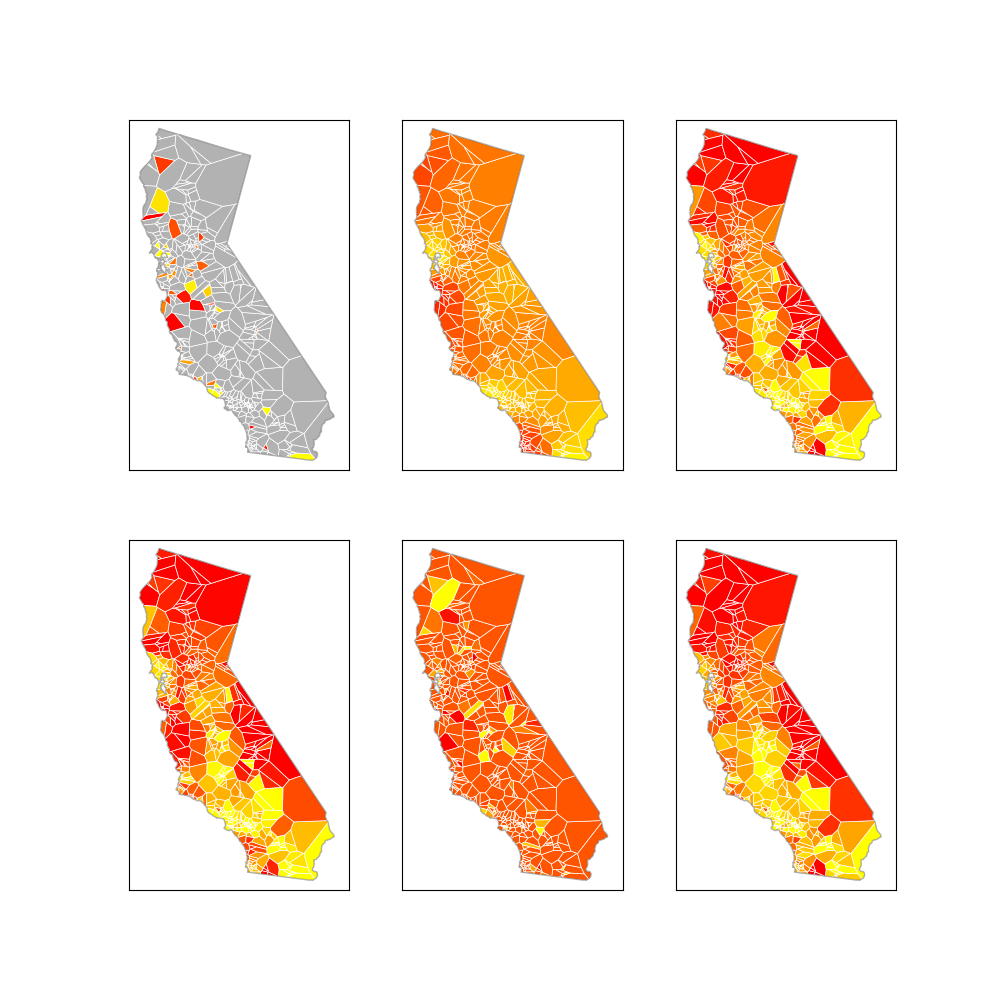

In [124]:

cali = np.load('../data/cali/cali_xy.npy')

contained = Path(cali).contains_points(sites[['x', 'y']].values)

regions = bounded_voronoi(points=sites.loc[contained, ['x', 'y']], boundary=cali)

def add_patches(ax, regions, colors=None, alpha=1):

    default_colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


    if colors is None:
        colors = default_colors[np.arange(len(regions)) % len(default_colors)]

    for i, region in enumerate(regions):

        for sub_region in region:

            ax.add_patch(PathPatch(Path(sub_region), alpha=alpha, facecolor=colors[i], edgecolor='white', linewidth=0.5))

    
# cols = to_colors(data.iloc[:4, contained].values, cmap='autumn')

fig, axes = plt.subplots(figsize=(10, 10), ncols=3, nrows=2, sharex=True, sharey=True)

vmin = predictions[0].iloc[1000].values.min()
vmax = predictions[0].iloc[1000].values.max()

add_patches(axes[0, 0], regions, colors=to_colors(Y0.iloc[1000], cmap='autumn', vmin=vmin, vmax=vmax))
add_patches(axes[0, 1], regions, colors=to_colors(predictions[0].iloc[1000], cmap='autumn', vmin=vmin, vmax=vmax))
add_patches(axes[0, 2], regions, colors=to_colors(predictions[1].iloc[1000], cmap='autumn', vmin=vmin, vmax=vmax))
add_patches(axes[1, 0], regions, colors=to_colors(predictions[2].iloc[1000], cmap='autumn', vmin=vmin, vmax=vmax))
add_patches(axes[1, 1], regions, colors=to_colors(predictions[3].iloc[1000], cmap='autumn', vmin=vmin, vmax=vmax))
add_patches(axes[1, 2], regions, colors=to_colors(predictions[4].iloc[1000], cmap='autumn', vmin=vmin, vmax=vmax))

for ax in axes.ravel():
    ax.add_patch(PathPatch(Path(cali), alpha=0.3, facecolor="none", edgecolor='black'))
    ax.set_xlim(-2.4e6, -1.6e6)
    ax.set_ylim(-5.5e5, 7.2e5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.savefig('cali_pred_map/cali_preds_plot.pdf')

subprocess.run(['pdfcrop', 'cali_pred_map/cali_preds_plot.pdf', 'cali_pred_map/cali_preds_plot.pdf'])

In [88]:
def cali_plot(save=False):

    cali = np.load('../data/cali/cali_xy.npy')

    contained = Path(cali).contains_points(sites[['x', 'y']].values)

    regions = bounded_voronoi(points=sites.loc[contained, ['x', 'y']], boundary=cali)

    def add_patches(ax, regions, colors=None, alpha=0.5):

        default_colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


        if colors is None:
            colors = default_colors[np.arange(len(regions)) % len(default_colors)]

        for i, region in enumerate(regions):

            for sub_region in region:

                ax.add_patch(PathPatch(Path(sub_region), alpha=alpha, facecolor=colors[i], edgecolor='white', linewidth=0.5))

        
    # cols = to_colors(data.iloc[:4, contained].values, cmap='autumn')

    fig, ax = plt.subplots(figsize=(5, 10))

    add_patches(ax, regions, colors=None, alpha=0.5)
    ax.scatter(sites.loc[contained, 'x'], sites.loc[contained, 'y'], s=5,)

    A, L = get_graph()

    for i in range(571):
        for j in range(571):

            if i == j:
                break

            if A[i, j]:

                plt.plot([sites['x'].values[i], sites['x'].values[j]], [sites['y'].values[i], sites['y'].values[j]], color='gray', alpha=0.5, lw=0.5, zorder=-1)


    ax.add_patch(PathPatch(Path(cali), alpha=0.3, facecolor="none", edgecolor='black'))
    ax.set_xlim(-2.4e6, -1.6e6)
    ax.set_ylim(-5.5e5, 7.2e5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    if save:

        plt.savefig('cali_plot2.pdf')

        subprocess.run(['pdfcrop', 'cali_plot2.pdf', 'cali_plot2.pdf'])

  0%|          | 0/571 [00:00<?, ?it/s]

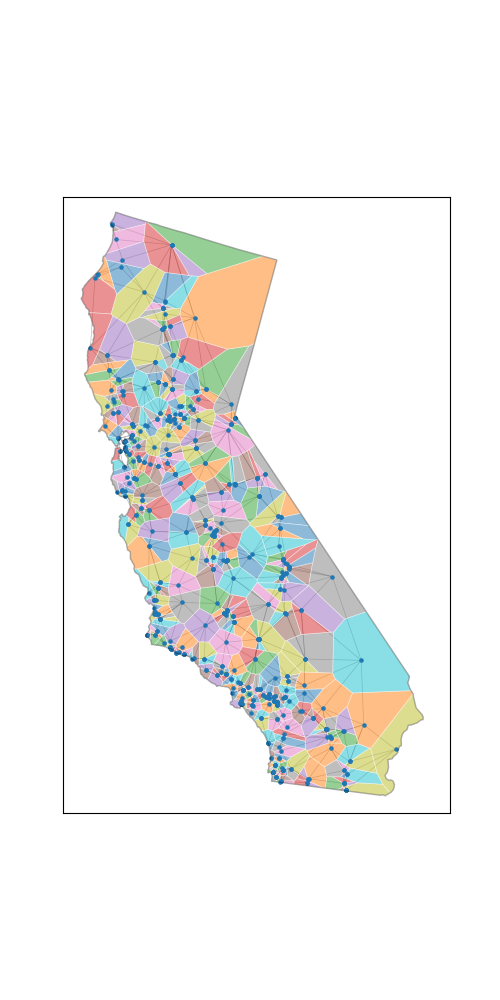

In [89]:
cali_plot()